In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'asl_dataset/train/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'asl_dataset/train/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [33]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

model_ckpt = ModelCheckpoint(
    'asl_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


In [34]:
input_layer = Input(shape=(160, 160, 3))

base_model = MobileNetV2(
    input_tensor=input_layer,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Phase 1: freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/var/folders/_c/06z__v850cl0lww428wdgzp40000gn/T/ipykernel_98794/1020458821.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, model_ckpt, lr_schedule]
)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3985 - loss: 2.2843
Epoch 1: val_accuracy improved from -inf to 0.68638, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 261s 118ms/step - accuracy: 0.3986 - loss: 2.2839 - val_accuracy: 0.6864 - val_loss: 1.0779 - learning_rate: 1.0000e-04
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8091 - loss: 0.5950
Epoch 2: val_accuracy improved from 0.68638 to 0.72305, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 237s 109ms/step - accuracy: 0.8092 - loss: 0.5950 - val_accuracy: 0.7230 - val_loss: 0.9266 - learning_rate: 1.0000e-04
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8705 - loss: 0.4019
Epoch 3: val_accuracy improved from 0.72305 to 0.73805, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 237s 109ms/step - accuracy: 0.8705 - loss: 0.4018 - val_accuracy: 0.7380 - val_loss: 0.8960 - learning_rate: 1.0000e-04
Epoc

In [36]:
base_model.trainable = True  # 🔓 Unfreeze MobileNetV2

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 🔽 Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_ckpt, lr_schedule]
)


Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6414 - loss: 1.4538
Epoch 1: val_accuracy improved from 0.78046 to 0.78310, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3726s 2s/step - accuracy: 0.6414 - loss: 1.4535 - val_accuracy: 0.7831 - val_loss: 0.8476 - learning_rate: 1.0000e-05
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9100 - loss: 0.2831
Epoch 2: val_accuracy improved from 0.78310 to 0.85236, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2875s 1s/step - accuracy: 0.9100 - loss: 0.2831 - val_accuracy: 0.8524 - val_loss: 0.5525 - learning_rate: 1.0000e-05
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9516 - loss: 0.1467
Epoch 3: val_accuracy improved from 0.85236 to 0.88230, saving model to asl_model_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2469s 1s/step - accuracy: 0.9516 - loss: 0.1467 - val_accuracy: 0.8823 - val_loss: 0.4519 - learning_rate: 1.0000e-05
Epoch 4/20
21

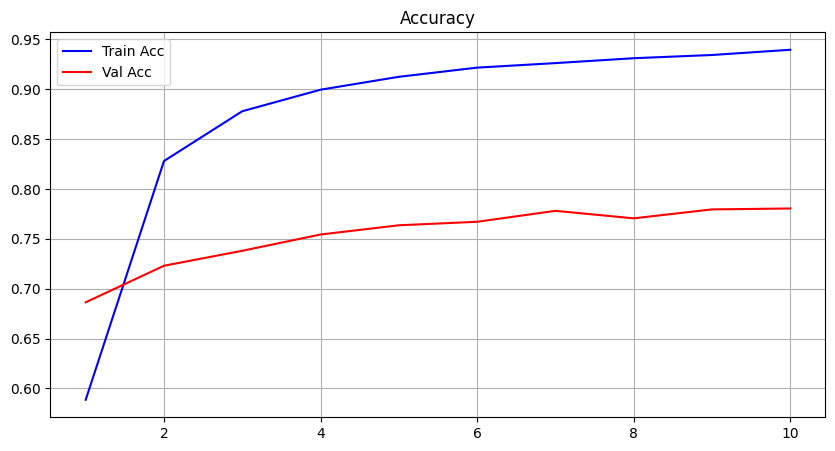

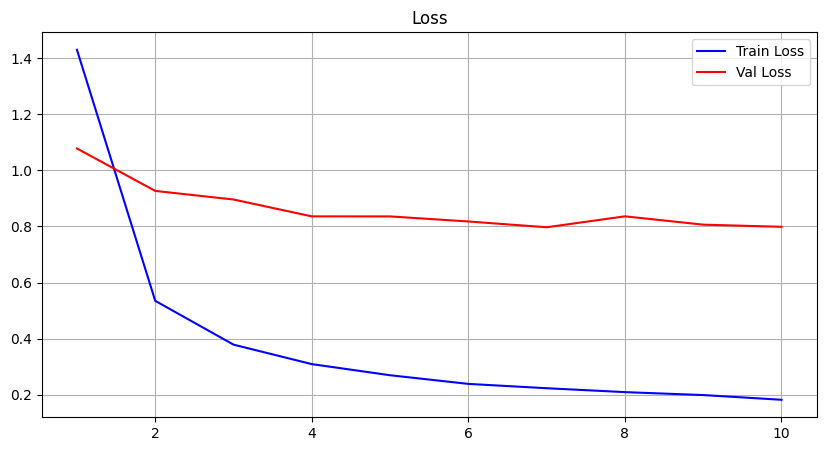

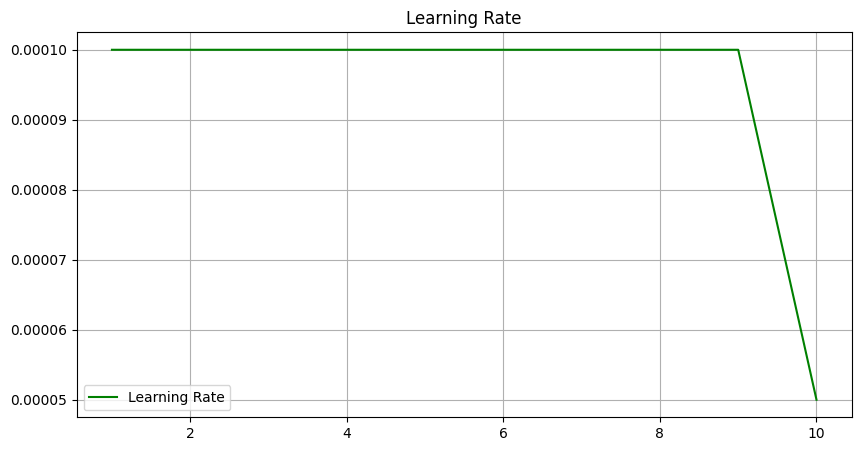

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history.get('learning_rate')

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b-', label='Train Acc')
plt.plot(epochs, val_acc, 'r-', label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

if lr:
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lr, 'g-', label='Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


In [38]:
model.save("asl_final_model.keras")


In [39]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 52s 93ms/step - accuracy: 0.9305 - loss: 0.2950
✅ Final Validation Accuracy: 0.9294
✅ Final Validation Loss: 0.3003


544/544 ━━━━━━━━━━━━━━━━━━━━ 58s 101ms/step


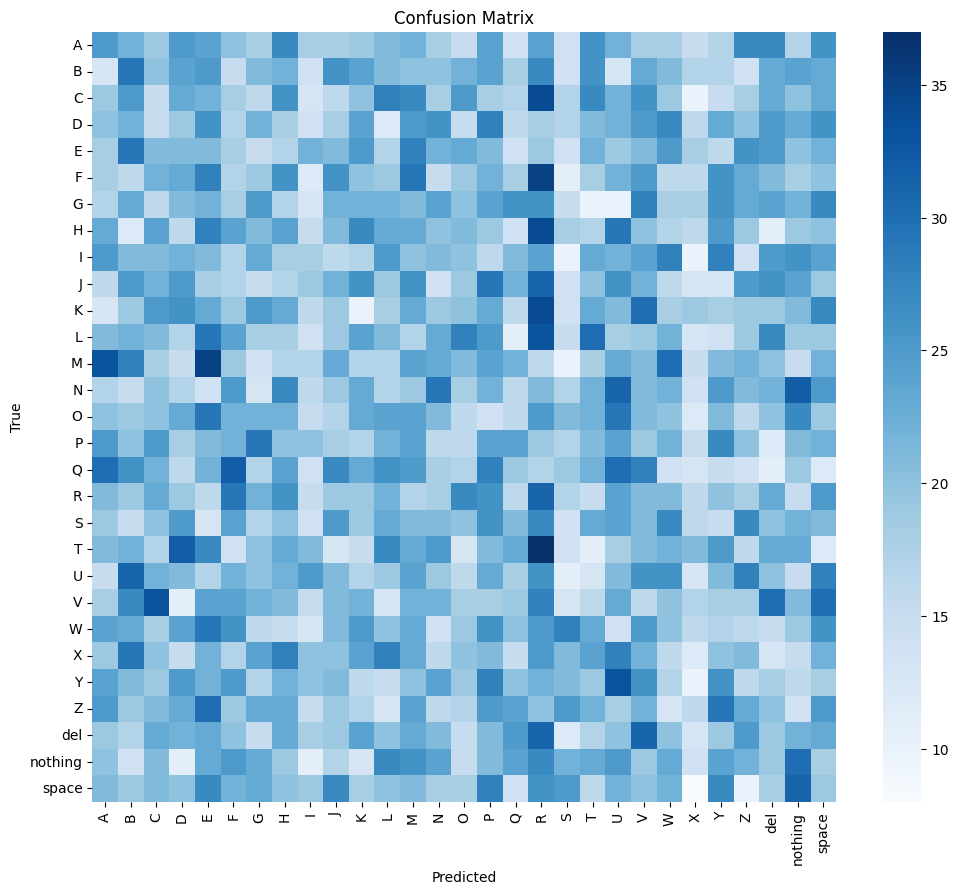

              precision    recall  f1-score   support

           A       0.04      0.04      0.04       600
           B       0.05      0.05      0.05       600
           C       0.02      0.03      0.02       600
           D       0.03      0.03      0.03       600
           E       0.03      0.04      0.03       600
           F       0.03      0.03      0.03       600
           G       0.04      0.04      0.04       600
           H       0.04      0.04      0.04       600
           I       0.04      0.03      0.03       600
           J       0.04      0.04      0.04       600
           K       0.02      0.02      0.02       600
           L       0.04      0.04      0.04       600
           M       0.04      0.04      0.04       600
           N       0.05      0.05      0.05       600
           O       0.03      0.03      0.03       600
           P       0.04      0.04      0.04       600
           Q       0.03      0.03      0.03       600
           R       0.04    

In [42]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))
